In [1]:
from GConvLSTM import GConvLSTMCell, Encoder, Decoder, GConvLSTM
from torchinfo import summary
import Get_data as Gd
import os
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA RTX A6000
Using device: cuda:0


# Create Dataset

In [3]:
directory = '/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

## Get the edge info

In [4]:
sparse_graph = scipy.sparse.load_npz('/data/Sibo_22Mar2024/sparse_matrix_fixed.npz')
indices = np.array(sparse_graph.nonzero())
values = sparse_graph.data
shape = sparse_graph.shape

# sparse edge tensor
edge_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float).coalesce()
edge_index = edge_tensor.indices()
edge_weight = edge_tensor.values()
print(edge_tensor.shape)
print(edge_index)
print(edge_weight)

torch.Size([97149, 97149])
tensor([[    0,     0,     1,  ..., 97148, 97148, 97148],
        [    1,     3,     0,  ..., 97145, 97146, 97147]])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


## Train set

In [5]:
train_nodes, length = Gd.get_all_nodes(folders[:-2])
train_seq_data = np.expand_dims(Gd.segment_data(train_nodes, length, 10, 5)[:, :, :, 0], axis = 3)
train_x_np = train_seq_data[:, :5, :, :]
train_y_np = train_seq_data[:, 5:, :, :]

preprocessor = Gd.Preprocessor()
# preprocessor.mean = 0
# preprocessor.std = 1
preprocessor.fit(train_seq_data)
preprocessed_train_x_np = preprocessor.transform(train_x_np)
preprocessed_train_y_np = preprocessor.transform(train_y_np)

# preprocessed_train_x_np = train_x_np
# preprocessed_train_y_np = train_y_np


In [6]:
preprocessed_train_x = torch.tensor(preprocessed_train_x_np, dtype=torch.float)
preprocessed_train_y = torch.tensor(preprocessed_train_y_np, dtype=torch.float)
real_y_train_tensor = torch.tensor(train_y_np, dtype=torch.float)
train_tensor_set = Gd.MyDataset(preprocessed_train_x, edge_index, edge_weight, preprocessed_train_y)
print(preprocessed_train_x.max(), preprocessed_train_y.max(), real_y_train_tensor.max())
print(preprocessed_train_x.min(), preprocessed_train_y.min(), real_y_train_tensor.min())

tensor(1.) tensor(1.) tensor(49.4879)
tensor(0.) tensor(0.) tensor(-2.5445)


In [7]:
a, b, c, d = train_tensor_set[0]
print(a.shape, b.shape, c.shape, d.shape, len(train_tensor_set))

torch.Size([5, 97149, 1]) torch.Size([2, 291032]) torch.Size([291032]) torch.Size([5, 97149, 1]) 532


# Test set

In [8]:
test_nodes, length = Gd.get_all_nodes(folders[-2:])
test_seq_data = np.expand_dims(Gd.segment_data(train_nodes, length, 10, 5)[:, :, :, 0], axis = 3)
test_x_np = test_seq_data[:, :5, :, :]
test_y_np = test_seq_data[:, 5:, :, :]

preprocessed_test_x_np = preprocessor.transform(test_x_np)
preprocessed_test_y_np = preprocessor.transform(test_y_np)

# preprocessed_test_x_np = test_x_np
# preprocessed_test_y_np = test_y_np

In [9]:
preprocessed_test_x = torch.tensor(preprocessed_test_x_np, dtype=torch.float)
preprocessed_test_y = torch.tensor(preprocessed_test_y_np, dtype=torch.float)

real_test_y_tensor = torch.tensor(test_y_np, dtype=torch.float)

test_tensor_set = Gd.MyDataset(preprocessed_test_x, edge_index, edge_weight, preprocessed_test_y)

In [10]:
print(preprocessed_test_x.max(), preprocessed_test_y.max(), real_test_y_tensor.max())
print(preprocessed_test_x.min(), preprocessed_test_y.min(), real_test_y_tensor.min())

tensor(0.8918) tensor(0.8918) tensor(43.8560)
tensor(0.0489) tensor(0.0489) tensor(-1.2132e-12)


In [11]:
x, y, z, f = train_tensor_set[0]
print(x.shape, y.shape, z.shape, f.shape, len(train_tensor_set))

torch.Size([5, 97149, 1]) torch.Size([2, 291032]) torch.Size([291032]) torch.Size([5, 97149, 1]) 532


# Model Info

In [12]:
hidden_dim = 16

# Create an instance of the model
encoder = Encoder(5, 1, hidden_dim, "cpu")
summary(encoder, input_data=(a, b, c))

Layer (type:depth-idx)                        Output Shape              Param #
Encoder                                       [5, 97149, 16]            --
├─ModuleList: 1-1                             --                        --
│    └─GConvLSTMCell: 2-1                     [97149, 16]               --
│    │    └─GCNConv: 3-1                      [97149, 64]               1,152
│    └─GConvLSTMCell: 2-2                     [97149, 16]               --
│    │    └─GCNConv: 3-2                      [97149, 64]               1,152
│    └─GConvLSTMCell: 2-3                     [97149, 16]               --
│    │    └─GCNConv: 3-3                      [97149, 64]               1,152
│    └─GConvLSTMCell: 2-4                     [97149, 16]               --
│    │    └─GCNConv: 3-4                      [97149, 64]               1,152
│    └─GConvLSTMCell: 2-5                     [97149, 16]               --
│    │    └─GCNConv: 3-5                      [97149, 64]               1,152
Total

In [13]:
_, (x, c_cur) = encoder(a, b, c)
decoder = Decoder(5, hidden_dim, 3)

summary(decoder, input_data=(x, c_cur, b, c))

Layer (type:depth-idx)                        Output Shape              Param #
Decoder                                       [5, 97149, 3]             --
├─GCNConv: 1-1                                [97149, 3]                3
│    └─Linear: 2-1                            [97149, 3]                48
│    └─SumAggregation: 2-2                    [97149, 3]                --
├─GCNConv: 1-2                                [97149, 3]                3
│    └─Linear: 2-3                            [97149, 3]                48
│    └─SumAggregation: 2-4                    [97149, 3]                --
├─ModuleList: 1-3                             --                        --
│    └─GConvLSTMCell: 2-5                     [97149, 3]                --
│    │    └─GCNConv: 3-1                      [97149, 12]               240
│    └─GConvLSTMCell: 2-6                     [97149, 3]                --
│    │    └─GCNConv: 3-2                      [97149, 12]               240
│    └─GConvLSTMCell

In [14]:
model = GConvLSTM(5, 5, 1, hidden_dim, "cpu")

summary(model, input_data=(a, b, c))

Layer (type:depth-idx)                             Output Shape              Param #
GConvLSTM                                          [5, 97149, 1]             --
├─Encoder: 1-1                                     [5, 97149, 16]            --
│    └─ModuleList: 2-1                             --                        --
│    │    └─GConvLSTMCell: 3-1                     [97149, 16]               1,152
│    │    └─GConvLSTMCell: 3-2                     [97149, 16]               1,152
│    │    └─GConvLSTMCell: 3-3                     [97149, 16]               1,152
│    │    └─GConvLSTMCell: 3-4                     [97149, 16]               1,152
│    │    └─GConvLSTMCell: 3-5                     [97149, 16]               1,152
├─Decoder: 1-2                                     [5, 97149, 1]             --
│    └─GCNConv: 2-2                                [97149, 1]                1
│    │    └─Linear: 3-6                            [97149, 1]                16
│    │    └─SumAggreg

# Train model

In [15]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [16]:
def train(model, train_set, real_y_train, test_set, real_y_test, criterion, optimizer, preprocessor, device, epochs=30):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        recon_train_loss = 0
        for (x, edge_index, edge_weight, y), real_y in zip(train_set, real_y_train):
            x, edge_index, edge_weight, y = x.to(device), edge_index.to(device), edge_weight.to(device), y.to(device)
            optimizer.zero_grad()
            predict= model(x, edge_index, edge_weight)
            loss = criterion(y, predict)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predict_np = predict.cpu().detach().numpy()
            recon_predict_np = preprocessor.inverse_transform(predict_np)
            recon_predict_tensor = torch.tensor(recon_predict_np, dtype=torch.float)
            recon_train_loss += criterion(real_y, recon_predict_tensor)

        train_loss /= len(train_set)
        recon_train_loss /= len(train_set)

        with torch.no_grad():
            val_loss = 0
            recon_test_loss = 0
            for (x, edge_index, edge_weight, y), real_y in zip(test_set, real_y_test):
                x, edge_index, edge_weight, y = x.to(device), edge_index.to(device), edge_weight.to(device), y.to(device)
                predict= model(x, edge_index, edge_weight)
                val_loss += criterion(y, predict).item()

                #print(criterion(output, sigmoid(data)))
                predict_np = predict.cpu().detach().numpy()
                recon_predict_np = preprocessor.inverse_transform(predict_np)
                recon_predict_tensor = torch.tensor(recon_predict_np, dtype=torch.float)
                recon_test_loss += criterion(real_y, recon_predict_tensor)

            val_loss /= len(test_set)
            recon_test_loss /= len(test_set)
        
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, recon train loss: {recon_train_loss}, val Loss: {val_loss}, recon val Loss: {recon_test_loss}')


In [17]:
model = C=GConvLSTM(5, 5, 1, hidden_dim, device).to(device)
optimizer = optim.Adam(model.parameters())
criterion = RMSELoss()

train(model, train_tensor_set, real_y_train_tensor, test_tensor_set, real_test_y_tensor, criterion, optimizer, preprocessor, device)
# 保存模型的状态字典
torch.save(model.state_dict(), 'model_weights.pth')

Epoch 1/100, train Loss: 0.10484673234431031, recon train loss: 5.455430030822754, val Loss: 0.121543421753143, recon val Loss: 6.324199676513672
Epoch 2/100, train Loss: 0.07908104715564225, recon train loss: 4.114779949188232, val Loss: 0.11908942970790361, recon val Loss: 6.196512222290039
Epoch 3/100, train Loss: 0.07803412597920549, recon train loss: 4.060304641723633, val Loss: 0.11853791910566781, recon val Loss: 6.167816162109375
Epoch 4/100, train Loss: 0.07770707341404702, recon train loss: 4.043287754058838, val Loss: 0.11837921360213506, recon val Loss: 6.1595587730407715
Epoch 5/100, train Loss: 0.07756568899875353, recon train loss: 4.035931587219238, val Loss: 0.11833129617336549, recon val Loss: 6.157064914703369
Epoch 6/100, train Loss: 0.0774696538368366, recon train loss: 4.0309343338012695, val Loss: 0.11830521923931021, recon val Loss: 6.155707836151123
Epoch 7/100, train Loss: 0.07738284782079377, recon train loss: 4.026417255401611, val Loss: 0.11827026748735654,

# Result

In [18]:
def draw_pic(model, real_x, x, edge_index, edge_weight, real_output, coords):
    print(x.device, edge_index.device, edge_weight.device)
    output = model(x, edge_index, edge_weight)

    # output.to("cpu")
    output_array = output.cpu().detach().numpy() # [5, 97149, 3]
    recon_output = preprocessor.inverse_transform(output_array)
    print(np.allclose(output_array, output.cpu().detach().numpy()))
    print(recon_output[:, :, 0].max(), real_output[:, :, 0].max())

    x_array = output.cpu().detach().numpy()
    recon_x = preprocessor.inverse_transform(x_array)

    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=real_x[i, :, 0], cmap='bwr')
        axs[i].set_title(f'Input {i+1}')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=recon_output[i, :, 0], cmap='bwr')
        axs[i].set_title(f'Predict {i+1}')
    plt.show()
    plt.close()

    fig3, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=real_output[i, :, 0], cmap='bwr')
        axs[i].set_title(f'Real output {i+1}')
    plt.show()
    plt.close()

In [19]:
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
xycoords_check = np.load(xyfile)

cuda:0 cuda:0 cuda:0
True
35.6656033403787 43.85604086630835


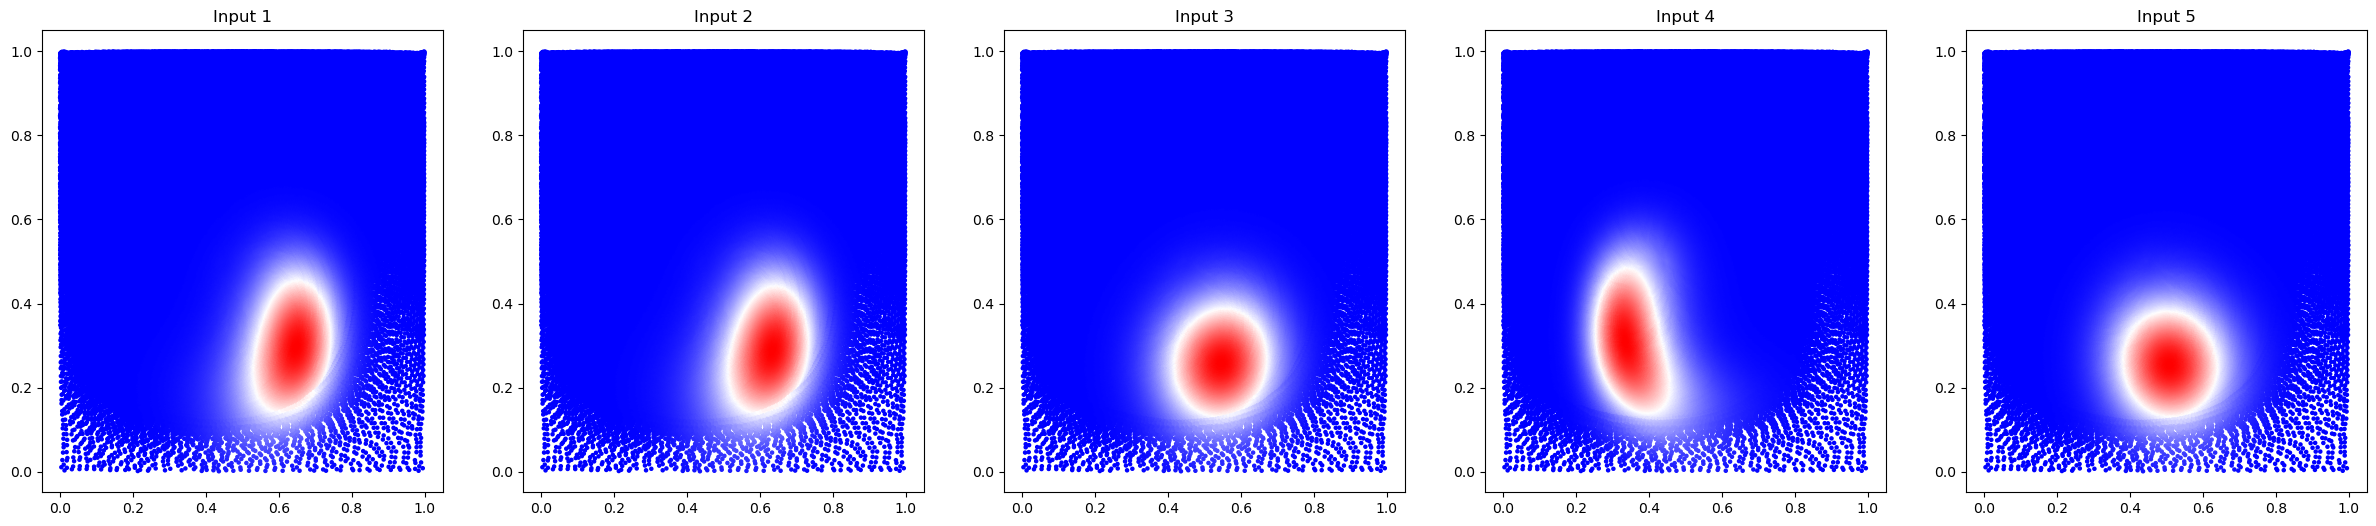

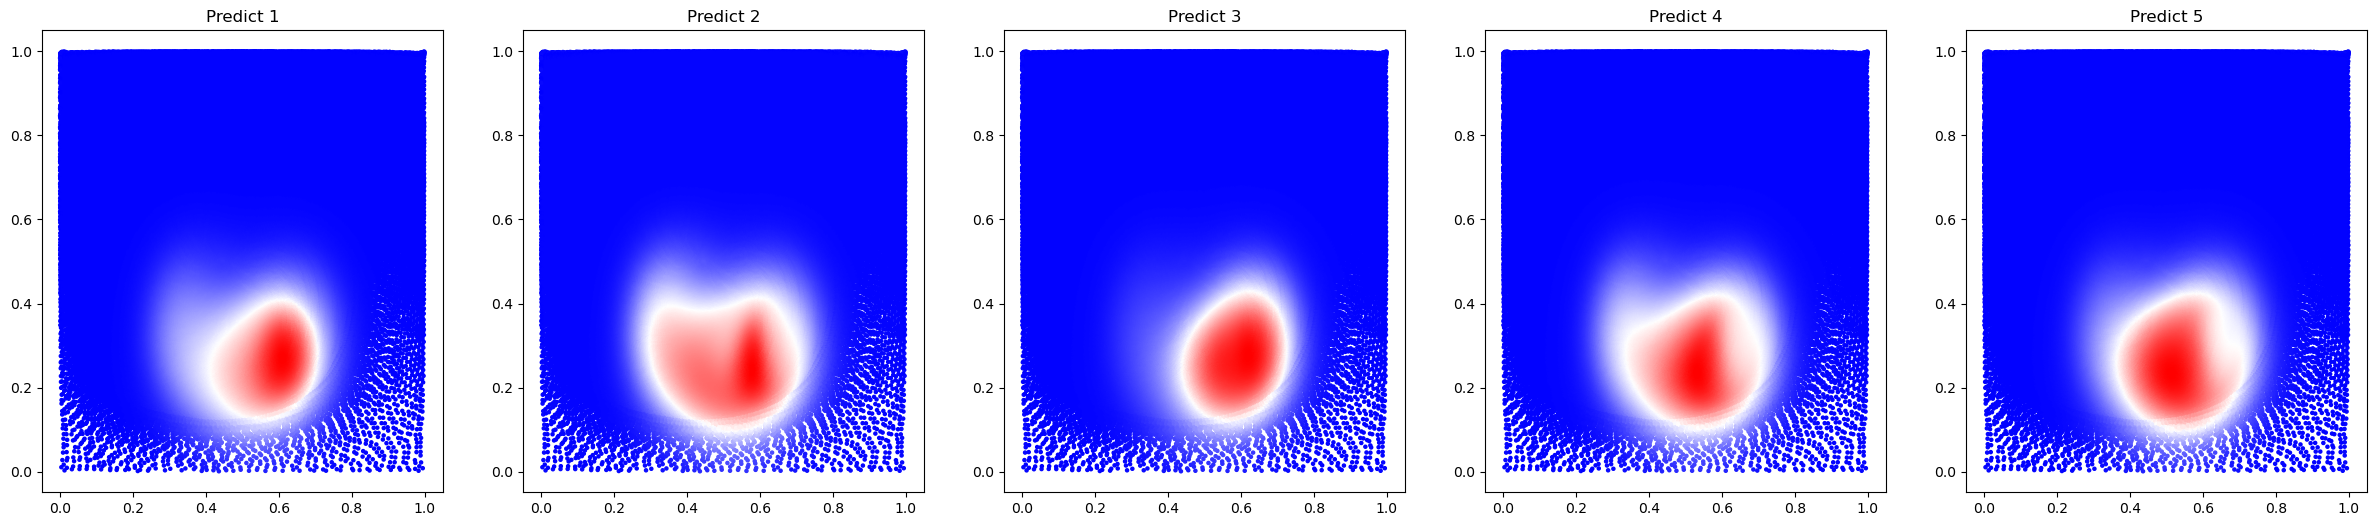

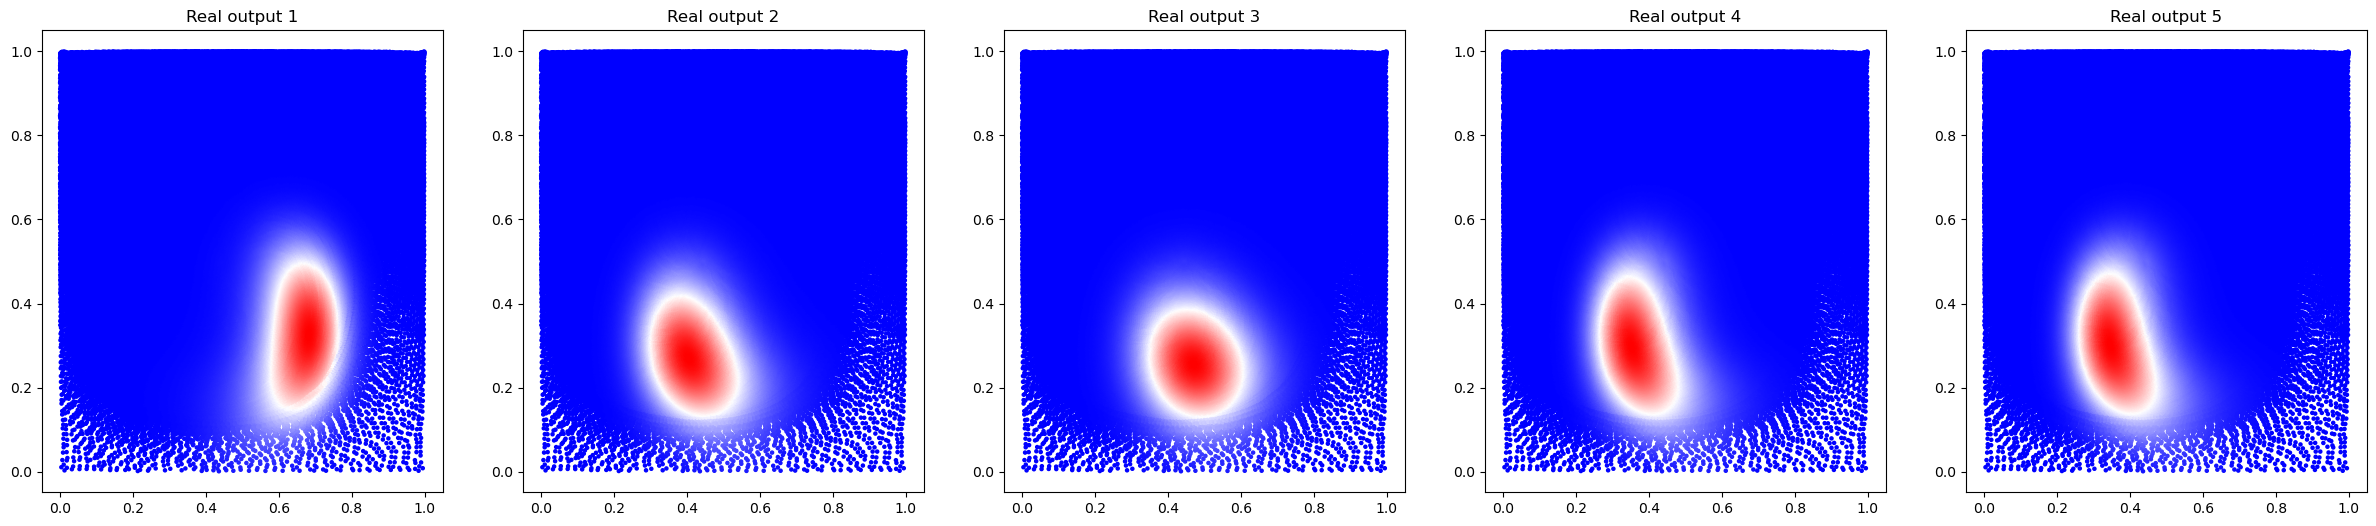

In [20]:
mmm = GConvLSTM(5, 5, 1, hidden_dim, device)
# 加载保存的状态字典
state_dict = torch.load('model_weights.pth')
mmm.load_state_dict(state_dict)
# 将模型迁移到指定的设备上，如 GPU
mmm.to(device)

real_x = test_x_np[0]
x, edge_index, edge_weight, y = test_tensor_set[0]
x, edge_index, edge_weight = x.to(device), edge_index.to(device), edge_weight.to(device)

real_output = test_y_np[0]

draw_pic(model, real_x, x, edge_index, edge_weight, real_output, xycoords_check)